**Text Summarization using Sequence-to-Sequence**

**What is Text Summarization in NLP?**

“Automatic text summarization is the task of producing a concise and fluent summary while preserving key information content and overall meaning”

There are broadly two different approaches that are used for text summarization:

Extractive Summarization
Abstractive Summarization

**Extractive Summarization**

We identify the important sentences or phrases from the original text and extract only those from the text. Those extracted sentences would be our summary. The below diagram illustrates extractive summarization:



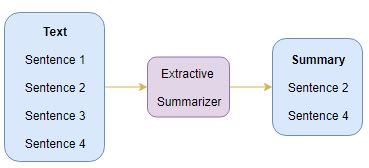

for building an extractive text summarizer using the TextRank algorithm

**Abstractive Summarization**

This is a very interesting approach. Here, we generate new sentences from the original text. This is in contrast to the extractive approach we saw earlier where we used only the sentences that were present. The sentences generated through abstractive summarization might not be present in the original text:

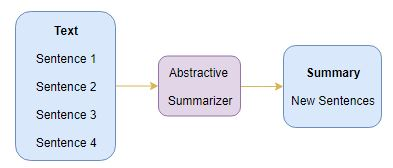

**Sequence-to-Sequence (Seq2Seq) Modeling**

We can build a Seq2Seq model on any problem which involves sequential information. This includes Sentiment classification, Neural Machine Translation, and Named Entity Recognition – some very common applications of sequential information.

Our objective is to build a text summarizer where the input is a long sequence of words (in a text body), and the output is a short summary (which is a sequence as well). So, we can model this as a Many-to-Many Seq2Seq problem. Below is a typical Seq2Seq model architecture

There are two major components of a Seq2Seq model:

Encoder
Decoder

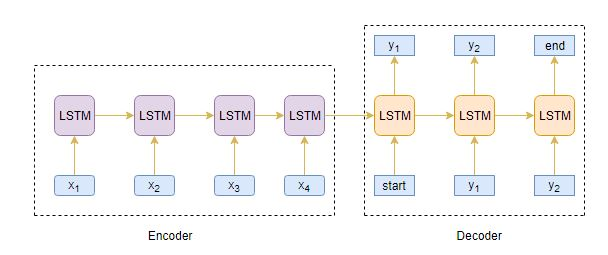

**Encoder-Decoder Architecture**

The Encoder-Decoder architecture is mainly used to solve the sequence-to-sequence (Seq2Seq) problems where the input and output sequences are of different lengths.

Let’s understand this from the perspective of text summarization. The input is a long sequence of words and the output will be a short version of the input sequence.

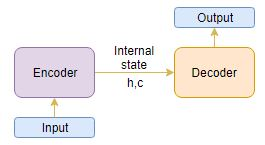

We preferred encoder and decoder components because they are capable of capturing long term dependencies by overcoming the problem of vanishing gradient.

We can set up the Encoder-Decoder in 2 phases:

Training phase & 
Inference phaseWE

**Encoder**

An Encoder Long Short Term Memory model (LSTM) reads the entire input sequence wherein, at each timestep, one word is fed into the encoder. It then processes the information at every timestep and captures the contextual information present in the input sequence.

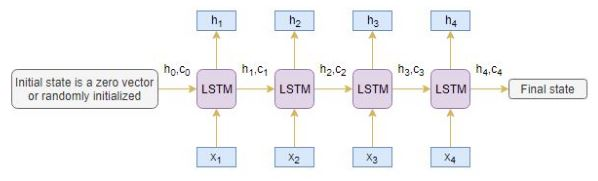

The hidden state (hi) and cell state (ci) of the last time step are used to initialize the decoder.

**Decoder**

The decoder is also an LSTM network which reads the entire target sequence word-by-word and predicts the same sequence offset by one timestep. The decoder is trained to predict the next word in the sequence given the previous word.


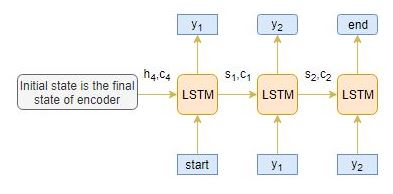

**Inference Phase**

After training, the model is tested on new source sequences for which the target sequence is unknown. So, we need to set up the inference architecture to decode a test sequence

Here are the steps to decode the test sequence:

Encode the entire input sequence and initialize the decoder with internal states of the encoder

Pass <start> token as an input to the decoder


Run the decoder for one timestep with the internal states


The output will be the probability for the next word. The word with the maximum probability will be selected


Pass the sampled word as an input to the decoder in the next timestep and update the internal states with the current time step


Repeat steps 3 – 5 until we generate <end> token or hit the maximum length of the target sequence

Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow as tf
import warnings
import random as rn
import os
import keras
from tqdm import trange
import sys
os.environ['PYTHONHASHSEED'] = '0'

# Setting the seed for numpy-generated random numbers
np.random.seed(37)

# # Setting the seed for python random numbers
rn.seed(1254)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The below code is to access files in google drive. We are providing access for our Google colab to work on the dataset in drive.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We have defined a function to fetch the Nth level parent directory from current directory

In [3]:
os.environ['PROJECT_PATH'] = '/content/gdrive/My Drive/Colab Notebooks/TextSummariser'

In [4]:
def get_parent_dir(n=1):
    """ returns the n-th parent dicrectory of the current
    working directory """
    #current_path = os.path.dirname(os.path.abspath(__file__))
    current_path = os.path.dirname(os.path.join(os.environ['PROJECT_PATH'],"Abstractive_Text_Summariser.ipynb")) 
    for k in range(n):
        current_path = os.path.dirname(current_path)
    return current_path

In [5]:
sys.path.append(get_parent_dir(0))

We use Tensorboard to log the plots for loss and accuracy int he folder named **logs**.

In [6]:
log_dir = os.path.join(get_parent_dir(0),"logs")
tbsw= TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', embeddings_freq=0)

**DataSet**

Link of the Dataset: https://www.kaggle.com/sunnysai12345/news-summary/code

The dataset consists  Headlines, Complete Article.

We check for the the desired missing values and load it in the variable **missing_values**

In [7]:
missing_values = ["n/a", "na", "--"]
data=pd.read_csv(os.path.join(get_parent_dir(0),"/content/gdrive/MyDrive/news_summary_more.csv"),na_values = missing_values)

##DATA CLEANING

**Finding null/missing values in dataset:**

We count the number of rows in our dataset.

In [8]:
data.count()

headlines    98401
text         98401
dtype: int64

We check for the count of null values.

In [9]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

No null data or missing data (including NA and our missing values list) is found in the dataset file. Hence the below dropna command drops nothing.

In [10]:
data.dropna(axis=0,inplace=True)

**Finding Duplicate data and dropping them:**

In [11]:
data.count()

headlines    98401
text         98401
dtype: int64

In [12]:
data.duplicated().sum()

22

In [13]:
data[data.duplicated()]

,headlines,text
51012,Longest Test innings was longer than 10 footba...,Former Pakistani cricketer Hanif Mohammad batt...
53731,"Captain once dropped himself, replacement brok...",England captain Mike Denness left himself out ...
55374,India marks National Mathematics Day in memory...,National Mathematics Day is celebrated on Dece...
58769,Indian bowler once took 2 hat-tricks in a sing...,Former Services' medium-pacer Joginder Rao pic...
59705,Why is England-Australia Test series called 'T...,England was beaten at home for the first time ...
60724,Sachin's debut was not telecast in India due t...,The Test in which Sachin Tendulkar made his in...
60885,Who is the cricketer with longest known surnam...,Fijian cricketer Ilikena Lasarusa Talebulamain...
62063,An ODI was once played in the middle of a Test...,Zimbabwe played an ODI against New Zealand in ...
62575,Virat Kohli took a wicket on the 0th ball of h...,Virat Kohli dismissed England's Kevin Pieterse...
63533,Bhabha convinced PM Nehru to start India's nuc...,"Born on October 30, 1909, Padma Bhushan-awarde..."


In [14]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)

In [15]:
data.count()

headlines    98379
text         98379
dtype: int64

In [16]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)

In [17]:

data.count()

headlines    98379
text         98379
dtype: int64

All duplicates have been removed.

##DATA PRE-PROCESSING

We prepare the contraction mapping dictionary for proper tokenisation.

In [18]:

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [19]:
stop_words = set(stopwords.words('english')) 

The text cleaner method cleans the text by removing short words (< 3 characters), special characters, numbers, HTML tags and also implementing contraction mapping and lower case conversion.

In [20]:
def text_cleaner(text):
  #To include a list of permitted words of length <=2 in a list
    allowed_short_words=['it','us','uk','ky','bu']
    newChars = text.lower()
    newChars = BeautifulSoup(newChars, "lxml").text
    newChars = re.sub(r'\([^)]*\)', '', newChars)
    newChars = re.sub('"','', newChars)
    newChars = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newChars.split(" ")])    
    newChars = re.sub(r"'s\b","",newChars)
    newChars = re.sub("[^a-zA-Z]", " ", newChars) 
    tokens = [w for w in newChars.split() if not w in stop_words]
    long_words=[]
    
    for i in tokens:
        if (len(i)>=3 or i in allowed_short_words):                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()
    

In [21]:
cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t))

The same is repeated for headlines data with a slight difference, say removing one letter words and not filtering stopwords.

In [22]:
def headlines_cleaner(text):
    newChars = re.sub('"','', text)
    newChars = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newChars.split(" ")])    
    newChars = re.sub(r"'s\b","",newChars)
    newChars = re.sub("[^a-zA-Z]", " ", newChars)
    newChars = newChars.lower()
    tokens=newChars.split()
    newChars=''
    for i in tokens:
        if len(i)>1:                                 
            newChars+=(i+' ')
    return newChars

#Call the above function and pass the headline column value
cleaned_headlines = []
for t in data['headlines']:
    cleaned_headlines.append(headlines_cleaner(t))


Replacing the empty values in cleaned headlines with numpy.nan to say that it is a missing value so that **dropna** command drops the row.

In [23]:
data['cleaned_headlines']=cleaned_headlines
data['cleaned_headlines'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [24]:
data['cleaned_text']=cleaned_text

In [25]:
data.head(20)


,headlines,text,cleaned_headlines,cleaned_text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit program machin...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,govt directs alok verma to join work day befor...,weeks cbi director alok verma told department ...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...,called pm modi sir times to satisfy his ego an...,andhra pradesh chandrababu naidu said met us p...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...


In [26]:
for i in range(18):
    print("News:",data['cleaned_text'][i])
    print("Headlines:",data['cleaned_headlines'][i])
    print("\n")

News: saurav kant alumnus upgrad iiit program machine learning artificial intelligence systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
Headlines: upgrad learner switches to career in ml al with salary hike 


News: kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit
Headlines: delhi techie wins free food from swiggy for one year on cred 


News: new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history
Headlines: new 

**Understanding the length distribution of news and headlines** 

We draw the histogram of news and headlines to fix the length of the predictions. 

In [27]:
import matplotlib.pyplot as plt
text_cnt = []
headlines_cnt = []

for i in data['cleaned_text']:
      text_cnt.append(len(i.split()))

for i in data['cleaned_headlines']:
      headlines_cnt.append(len(i.split()))

length_dist = pd.DataFrame({'Text':text_cnt, 'Headlines':headlines_cnt})
length_dist.head(20)


,Text,Headlines
0,37,11
1,45,12
2,38,10
3,34,9
4,33,13
5,34,10
6,35,12
7,33,11
8,25,11
9,34,10


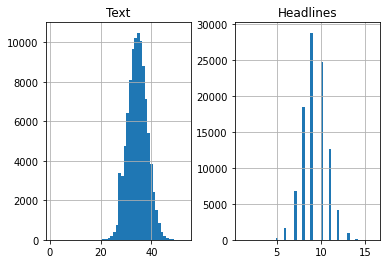

In [28]:
length_dist.hist(bins = 50)
plt.show()

The histograms convey that most of the headlines are 11 words in length and maximum news length is around 40 words in length.

The proportion of cleaned and preprocessed text and headlines with word count less than 30 and 11 is measured.


In [29]:
per=0
for i in data['cleaned_headlines']:
    if(len(i.split())<=11):
        per=per+1
print(per/len(data['cleaned_headlines']))

0.9470720377316297


In [30]:
per=0
for i in data['cleaned_text']:
    if(len(i.split())<=40):
        per=per+1
print(per/len(data['cleaned_text']))

0.9439107939702579


We observe that 94% of the summaries and text have length below 11 and below 40 respectively. So, we can fix maximum length of summary to 11.  Similarly fixing the maximum length of text to 40.

In [31]:
max_len_text=40
max_len_headlines=11

We select the text and headlines whose length falls below or equal to max_text_len and max_summary_len for further processing.

In [32]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_headlines=np.array(data['cleaned_headlines'])

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_headlines[i].split())<=max_len_headlines and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])
        
df=pd.DataFrame({'text':short_text,'headlines':short_headlines})

Adding prefix and suffix to headlines as "stok" and "etok" respectively to help in the training and validation procedure.

In [33]:
df['headlines'] = df['headlines'].apply(lambda x : 'stok '+ x + ' etok')


In [34]:
for i in range(18):
    print("News:",df['text'][i])
    print("Headlines:",df['headlines'][i])
    print("\n")

News: saurav kant alumnus upgrad iiit program machine learning artificial intelligence systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
Headlines: stok upgrad learner switches to career in ml al with salary hike  etok


News: new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history
Headlines: stok new zealand end rohit sharma led india match winning streak  etok


News: aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years
Headlines: stok aegon life iterm 

**TRAINING/VALIDATION DATA SPLIT**

We use train_test_split duntion from sklearn to split the news and summary into deterministic training and testing datasets. To enable deterministic split, we assign an integer value to random_state.

In [35]:
from sklearn.model_selection import train_test_split
#including headlines and news factors in variables to shorten the variables for further processing - np.array() added test
train_text, test_text, train_headlines, test_headlines = train_test_split(np.array(df['text']), np.array(df['headlines']), test_size=0.1,random_state=0,shuffle=True)

In [36]:
train_text.shape[0], test_text.shape[0], train_headlines.shape[0],test_headlines.shape[0]

(79084, 8788, 79084, 8788)

**Tokenisation**

A tokenizer converts sentences to tokens  which are then converted to integer sequence to help in further processing for training the model.

In [37]:
text_tokeniser=Tokenizer()


The below command fits the tokeniser on the training data where internal vocabulary is updated based on a list of texts. It creates the vocabulary index based on word frequency.

In [38]:
text_tokeniser.fit_on_texts(list(train_text))

In [39]:
text_tokeniser.word_counts.items()

odict_items([('government', 9270), ('tuesday', 3770), ('said', 43239), ('decided', 953), ('deregister', 2), ('lakh', 3780), ('companies', 1228), ('various', 638), ('non', 1036), ('compliances', 2), ('crackdown', 185), ('shell', 105), ('earlier', 4746), ('nearly', 1829), ('deregistered', 13), ('directors', 236), ('associated', 167), ('disqualified', 80), ('around', 3495), ('cases', 1181), ('filed', 1904), ('national', 3150), ('company', 4824), ('law', 1588), ('tribunal', 291), ('restoration', 49), ('added', 13858), ('us', 11284), ('president', 7130), ('donald', 2313), ('trump', 4102), ('wednesday', 3749), ('slammed', 1158), ('uk', 1671), ('theresa', 136), ('may', 2470), ('twitter', 2279), ('criticising', 159), ('retweet', 11), ('anti', 1036), ('muslim', 751), ('videos', 498), ('posted', 1211), ('british', 904), ('far', 735), ('right', 1306), ('group', 2815), ('leader', 2892), ('claimed', 4330), ('show', 1889), ('immigrant', 42), ('hitting', 246), ('dutch', 94), ('boy', 1072), ('muslims'

**Rarewords and its Coverage for text**

The below snippet computes the proportion of rare words and its total coverage in the entire text
The threshold is defined to be 4 which means words in news text whose count is below 4 in the entire document is considered as a rare word

In [40]:

threshold=4

count=0
tot_count=0
freq=0
tot_freq=0

for key,word in text_tokeniser.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+word
    if(word<threshold):
        count=count+1
        freq=freq+word

print(tot_count, tot_freq, count, freq)   
print("% of rare words in vocabulary:",(count/tot_count)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

68468 2709805 39359 59272
% of rare words in vocabulary: 57.48524858327978
Total Coverage of rare words: 2.1873160614878193


*   tot_count gives the count of unique words in the whole text.

*   count gives the number of rare words whose count falls below threshold

*   (tot_count - count) gives  the count of common words int he text.





The training data tokens are then converted to integer sequence for the most common words. The same tokeniser is used on the testing data to tokenise and convert into an integer sequence. This is followed by padding until maximum length is reached.

In [41]:

#prepare a tokenizer for reviews on training data
text_tokeniser = Tokenizer(num_words=tot_count-count) 
text_tokeniser.fit_on_texts(list(train_text))
train_text=text_tokeniser.texts_to_sequences(train_text)
test_text=text_tokeniser.texts_to_sequences(test_text)
train_text=pad_sequences(train_text,max_len_text,padding='post')
test_text=pad_sequences(test_text,max_len_text,padding='post')
#size of vocabulary ( +1 for padding token)

text_voc   =  text_tokeniser.num_words + 1

In [42]:
text_dict_size=len(text_tokeniser.word_index)+1
text_dict_size, text_voc, len(train_text)

(68469, 29110, 79084)

**Headlines Tokeniser**

In [43]:
headlines_tokeniser=Tokenizer()
#headlines_tokeniser.fit_on_texts(list(df['headlines']))
headlines_tokeniser.fit_on_texts(list(train_headlines))


**Rarewords and its Coverage for headlines**

In [44]:
headlines_thresh=5 #shd the threshold of summary be lesser or higher than that of news (text) - clar

count=0
tot_count=0
freq=0
tot_freq=0

for key,val in headlines_tokeniser.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+val
    if(val<headlines_thresh):
        count=count+1
        freq=freq+val
print(tot_count,count,tot_freq,freq)   
print("% of rare words in vocabulary:",(count/tot_count)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

30014 18414 879941 31850
% of rare words in vocabulary: 61.35136936096488
Total Coverage of rare words: 3.619560856921089


The same tokenisation procedure is followed for headlines as implemented for text.

In [45]:
headlines_tokeniser = Tokenizer(num_words=tot_count-count) 
headlines_tokeniser.fit_on_texts(list(train_headlines))

train_headlines=headlines_tokeniser.texts_to_sequences(train_headlines)
test_headlines=headlines_tokeniser.texts_to_sequences(test_headlines)

train_headlines=pad_sequences(train_headlines,max_len_headlines,padding='post')
test_headlines=pad_sequences(test_headlines,max_len_headlines,padding='post')
headlines_voc  =   headlines_tokeniser.num_words +1

In [46]:
headlines_voc, len(train_headlines)

(11601, 79084)

In [47]:
#Checking if all headlines are prefixed
headlines_tokeniser.word_counts['stok'],len(train_headlines)

(79084, 79084)

In [48]:
print(len(train_headlines))

79084


In [49]:
train_headlines.shape


(79084, 11)

The below snippet deletes headlines with only 2 words (stok and etok)

In [50]:
ind=[]
for i in range(len(train_headlines)): 
    count=0
    for j in train_headlines[i]:
        
        if j!=0:           
            count=count+1
    if(count==2):
        ind.append(i)
        #print(train_headlines[ind])
#print(cnt)
train_headlines=np.delete(train_headlines,ind, axis=0)
train_text=np.delete(train_text,ind, axis=0)

In [51]:
ind=[]
for i in range(len(test_headlines)):
    count=0
    for j in test_headlines[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

test_headlines=np.delete(test_headlines,ind, axis=0)
test_text=np.delete(test_text,ind, axis=0)

In [52]:
train_headlines[:]

array([[   1,   21,    3, ..., 3350,    2,    0],
       [  28,  189,   80, ...,  501, 6205,    2],
       [1843,    5, 3710, ...,    4,   25,    2],
       ...,
       [   1,   37,   31, ...,    2,    0,    0],
       [   1,   24,   35, ...,  710,  824,    2],
       [  28,   75, 1429, ...,   17, 1235,    2]], dtype=int32)

In [53]:
text_voc

29110

##MODEL BUILDING
Some of the important parameters used in the LSTM model are given below:

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. We use a 5 stacked LSTM encoder for better representation of the input sequence. <br>
The dropout parameters are assigned with value > 0 to avoid overfitting.

In [54]:
from keras import backend as K 
K.clear_session()


latent_dim = 300 
embed_dim=100 

# Encoder
enc_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_embed =  Embedding(text_voc, embed_dim,trainable=True)(enc_inputs)
#encoder lstm 1.setting dropout , recurrent_dropout to 0.4 inorder to avoid overfitting.
enc_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4) 
enc_output1, state_h1, state_c1 = enc_lstm1(enc_embed)

#encoder lstm 2
enc_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
enc_output2, state_h2, state_c2 = enc_lstm2(enc_output1)

#encoder lstm 3
enc_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
enc_output3, state_h3, state_c3= enc_lstm3(enc_output2)

#encoder lstm 4
enc_lstm4=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
enc_output4, state_h4, state_c4= enc_lstm4(enc_output3)

#encoder lstm 5
enc_lstm5=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
enc_outputs, state_h, state_c= enc_lstm5(enc_output4)

# Set up the decoder, using `encoder_states` as initial state.
dec_inputs = Input(shape=(None,))

#embedding layer
dec_embed_layer = Embedding(headlines_voc, embed_dim,trainable=True)
dec_embed = dec_embed_layer(dec_inputs)

#decoding layer
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
dec_outputs,dec_fwd_state, dec_back_state = dec_lstm(dec_embed,initial_state=[state_h, state_c])

# Concat attention input and decoder LSTM output
dec_concat_input = Concatenate(axis=-1, name='concat_layer')([dec_outputs])

#dense layer
dec_dense =  TimeDistributed(Dense(headlines_voc, activation='softmax'))
dec_outputs = dec_dense(dec_concat_input)

# Define the model 
model = Model([enc_inputs, dec_inputs], dec_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      2911000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 40, 300), (N 721200      lstm[0][0]                       
______________________________________________________________________________________________

Adam optimiser is used for finetuning the model.

In [55]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

Early Stopping is used to stop training the neural network at the right time by monitoring the validation loss as specified. Model will stop training once the validation loss increases in more than 2 epochs defined as "patience" factor.

In [56]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

In [57]:
train_headlines.shape[0],train_headlines.shape[1], train_text.shape

(79084, 11, (79084, 40))

In [58]:
train_headlines[:,:-1]

array([[   1,   21,    3, ...,  172, 3350,    2],
       [  28,  189,   80, ...,  284,  501, 6205],
       [1843,    5, 3710, ...,  752,    4,   25],
       ...,
       [   1,   37,   31, ...,  762,    2,    0],
       [   1,   24,   35, ...,  543,  710,  824],
       [  28,   75, 1429, ..., 6043,   17, 1235]], dtype=int32)

Training the model on a batch size of 128 and validating it on the holdout set (which is 10% of our dataset) as shown below. The weights are saved for use while detecting/predicting summaries.

In [59]:
train_text.shape,train_headlines[:,:-1].shape, train_headlines.reshape(train_headlines.shape[0],train_headlines.shape[1], 1)[:,1:].shape

((79084, 40), (79084, 10), (79084, 10, 1))

## TRAINING


In [ ]:
history=model.fit([train_text,train_headlines[:,:-1]], train_headlines.reshape(train_headlines.shape[0],train_headlines.shape[1], 1)[:,1:] ,epochs=15,callbacks=[tbsw, es],batch_size=128, validation_data=([test_text,test_headlines[:,:-1]], test_headlines.reshape(test_headlines.shape[0],test_headlines.shape[1], 1)[:,1:]))

print(history.history.keys())

model.save_weights(os.path.join(get_parent_dir(0),"s2s_lstm_weights_adam.h5"),overwrite=True)

Epoch 1/15
618/618 [==============================] - 566s 892ms/step - loss: 6.4917 - val_loss: 6.1124
Epoch 2/15
618/618 [==============================] - 545s 881ms/step - loss: 6.0260 - val_loss: 5.8369
Epoch 3/15
618/618 [==============================] - 535s 866ms/step - loss: 5.7580 - val_loss: 5.6373
Epoch 4/15
618/618 [==============================] - 530s 858ms/step - loss: 5.5338 - val_loss: 5.4684
Epoch 5/15
618/618 [==============================] - 530s 857ms/step - loss: 5.3304 - val_loss: 5.3167
Epoch 6/15
618/618 [==============================] - 532s 860ms/step - loss: 5.1425 - val_loss: 5.1809
Epoch 7/15
618/618 [==============================] - 528s 854ms/step - loss: 4.9567 - val_loss: 5.0578
Epoch 8/15
618/618 [==============================] - 528s 854ms/step - loss: 4.7978 - val_loss: 4.9684
Epoch 9/15
618/618 [==============================] - 533s 862ms/step - loss: 4.6616 - val_loss: 4.8900
Epoch 10/15
618/618 [==============================] - 524s 848m

In [ ]:
from tensorflow.keras.models import load_model

model.load_weights(os.path.join(get_parent_dir(0),"s2s_lstm_weights_adam.h5"))

## LOADING WEIGHTS OF THE TRAINED MODEL

The below code needs to be executed if training is not executed in the above step.

In [ ]:
model.summary()

##DIAGNOSTIC PLOT

Since the plot has been drawn after training the model, the same has been saved in path for visualisation while detecting summaries.

In [ ]:
from IPython.display import Image
Image(os.path.join(get_parent_dir(0), "LossPlot.png"))


After 14th epoch, the validation_loss has started increasing and hence the training is stopped by early stopping mechanism after 2 more epochs.

Next, a dictionary is built to convert the index to word for target and source vocabulary:

In [ ]:
reverse_target_word_index=headlines_tokeniser.index_word
reverse_source_word_index=text_tokeniser.index_word
target_word_index=headlines_tokeniser.word_index
reverse_target_word_index[0]="default"

## INFERENCE

Inference for encoder and decoder:

In [ ]:
# Encode the input sequence to get the feature vector
enc_model = Model(inputs=enc_inputs,outputs=[enc_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_embed4= dec_embed_layer(dec_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
dec_outputs4, state_h4, state_c4 = dec_lstm(dec_embed4, initial_state=[dec_state_input_h, dec_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([dec_hidden_state_input, dec_outputs4])
dec_inf_concat = Concatenate(axis=-1, name='concat')([dec_outputs4, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
dec_outputs4 = dec_dense(dec_inf_concat) 

# Final decoder model
dec_model = Model(
    [dec_inputs] + [dec_hidden_state_input,dec_state_input_h, dec_state_input_c],
    [dec_outputs4] + [state_h4, state_c4])

**Decoding - Implementation**

In [ ]:
def decode_sequence(input_seq):
    # Encoding input as state vectors.
    e_out, e_h, e_c = enc_model.predict(input_seq)
    
    # Empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # First word of target sequence is the start word.
    target_seq[0, 0] = target_word_index['stok']

    stop_condition = False
    dec_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = dec_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sampling a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index==0:
          print("sampled token: {}".format(sampled_token_index))
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='etok'):
            dec_sentence += ' '+sampled_token

        # either hit max length or stop word is the exit condition.
        if (sampled_token == 'etok'  or len(dec_sentence.split()) >= (max_len_headlines-1)):
            stop_condition = True

        #  target sequence updated (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        e_h, e_c = h, c

    return dec_sentence

Integer Sequence to summary and text conversion methods:


In [ ]:
def seqTosummary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['stok']) and i!=target_word_index['etok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seqTotext(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## GENERATION OF SUMMARY

In [ ]:
for i in range(0,18):
    print("Review:",seqTotext(train_text[i]))
    print("Original summary:",seqTosummary(train_headlines[i]))
    print("Predicted summary:",decode_sequence(train_text[i].reshape(1,max_len_text)))
    print("\n")

**Random Paragraph**

In [ ]:
def read_article(file_name):
    file = open(file_name, "r")
    filedata = file.readlines()
    article = filedata[0].split(". ")
    sentences = []
    print('ORIGINAL TEXT:\n')
    for sentence in article:
        print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))  
        
    return sentences

In [ ]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1

    return 1 - cosine_distance(vector1, vector2)

In [ ]:
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
            
    return similarity_matrix

In [ ]:
def generate_summary(file_name, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)
    #print(sentences)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    #print("Indexes of top ranked_sentence order are ", ranked_sentence)

    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    print("\nSUMMARIZED TEXT: \n\n", ". ".join(summarize_text))

In [ ]:
generate_summary('text1.txt',2)

In [ ]:
generate_summary('sample.txt',5)

**Conclusion**

By  increase the training dataset size and build the model. The generalization capability of a deep learning model enhances with an increase in the training dataset size.


Try implementing Bi-Directional LSTM which is capable of capturing the context from both the directions and results in a better context vector



**Reference Links:**<br>
https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b

https://www.blog.pythonlibrary.org/2018/10/24/working-with-jupyter-notebook-widgets/

https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#Label

https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/

https://pypi.org/project/py-rouge/

https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

Save model - https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model